In [1]:
from typing import Union, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from xai.data.reader import read_data
from xai.models import LightGBMModel, LogisticRegressionModel, NaiveBayesModel
from xai.validation import HoldOutValidation

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 500)

# 1)

In [2]:
features, target = read_data('data/hotel_bookings.csv')

In [3]:
features.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,Resort Hotel,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,Resort Hotel,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,Resort Hotel,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,Resort Hotel,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


In [4]:
validation = HoldOutValidation(test_size=0.1, random_state=42)

(X_train, y_train), (X_test, y_test) = next(validation.split(features, target))

In [5]:
model_classes = [LightGBMModel, LogisticRegressionModel, NaiveBayesModel]
model_params = [dict(n_estimators=250, learning_rate=0.007, max_depth=-1, num_leaves=64),
                dict(C=3), dict(var_smoothing=.3)]

In [6]:
models = [_class(**_params).fit(X_train, y_train) for _class, _params in zip(model_classes, model_params)]

# 2)

In [7]:
def permutation_importance(model, X, y, n_repeats: int = 1, max_features: int = 8):
    from sklearn.inspection import permutation_importance
    X = model._feature_engineering(X, y, train=False)
    result = permutation_importance(model.model, X, y, n_repeats=n_repeats, random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    
    importance_mean = result.importances_mean[perm_sorted_idx][-max_features:]
    importance_std = result.importances_std[perm_sorted_idx][-max_features:]
    features = X.columns[perm_sorted_idx][-max_features:]

    x = np.arange(max_features)
    bar_width = 0.5
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(24, 8), facecolor='w')
    plt.barh(x, importance_mean, height=bar_width, color='#00B1EB')
    plt.yticks(x, features, fontsize=18)
    plt.errorbar(importance_mean, x, 
                 xerr=importance_std, 
                 fmt='|', 
                 markersize=20, 
                 label='.',
                 yerr=None, 
                 color='black', 
                 ls='none', 
                 lolims=True, 
                 uplims=True, 
                 capsize=10)
    plt.title(model.__class__.__name__, fontsize=32)
    plt.show()

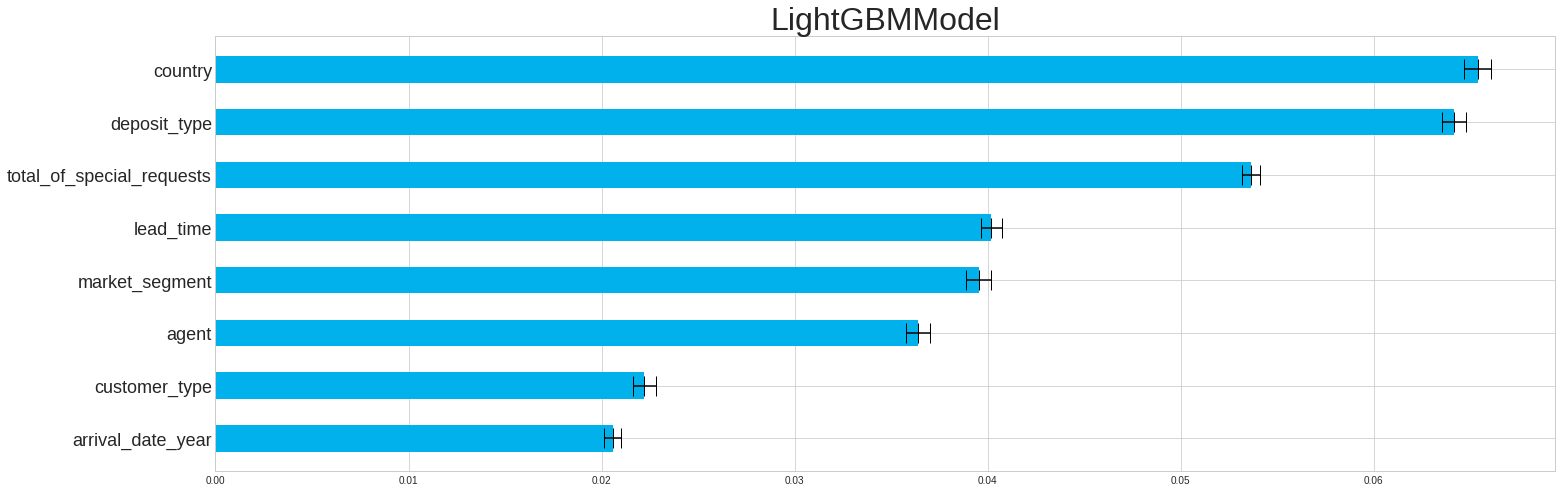

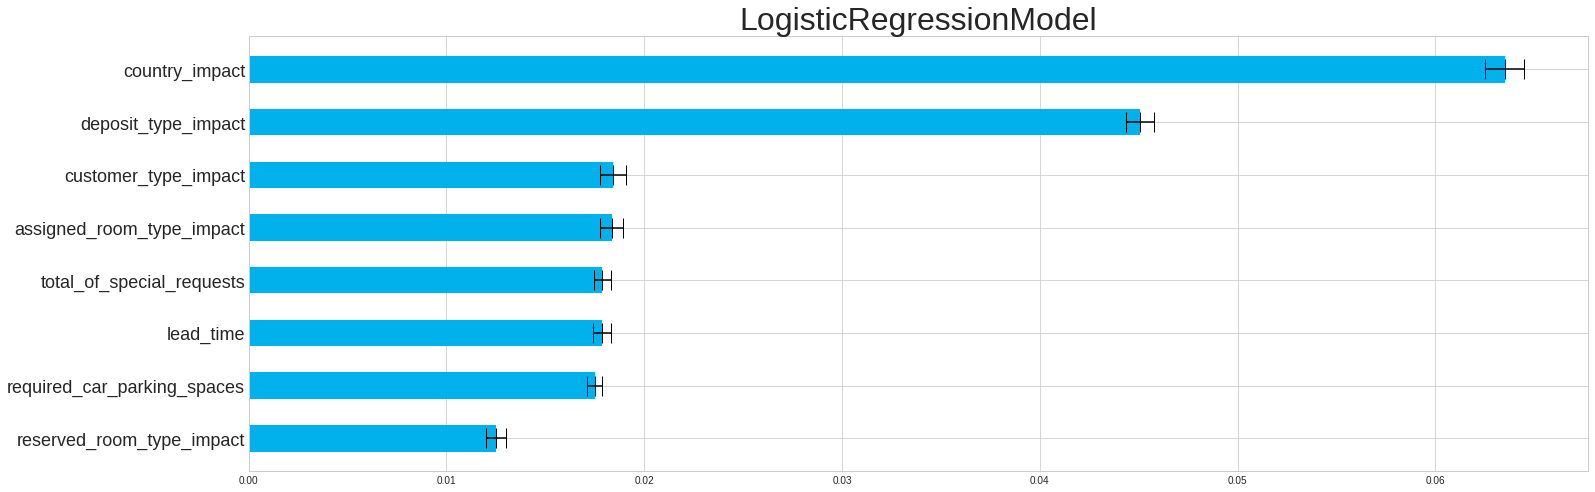

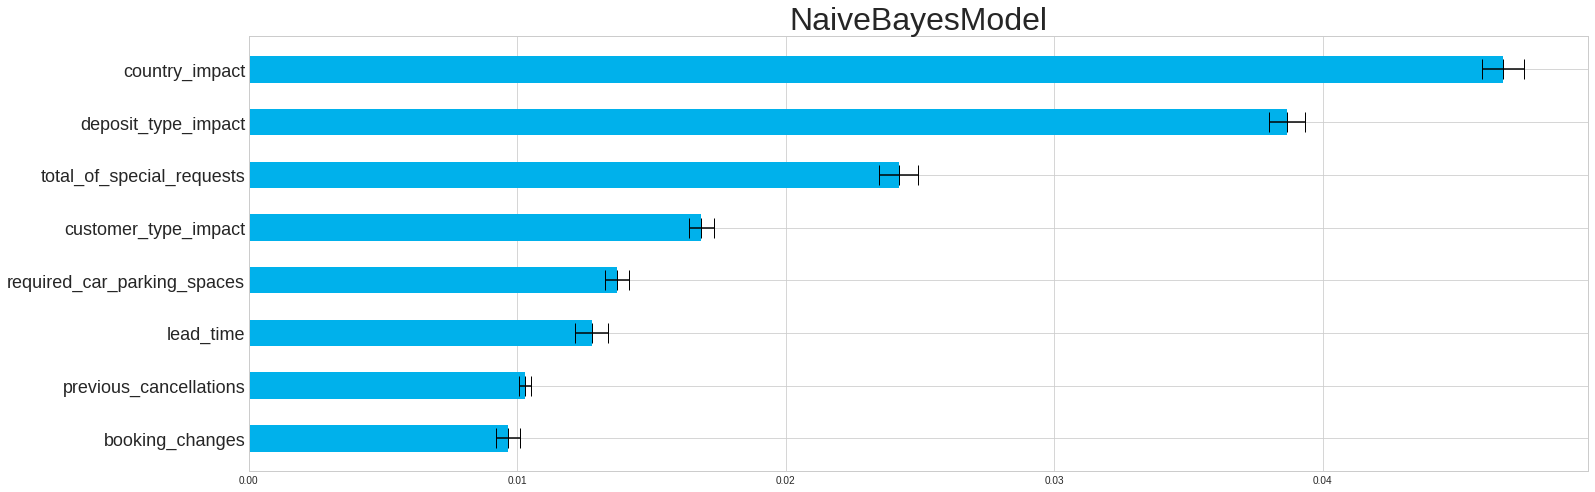

In [8]:
for model in models:
    permutation_importance(model, X_train, y_train, n_repeats=10)

In [9]:
data = features.copy()
data['TARGET'] = target.values
data['index'] = data.index

In [10]:
num_reservations_per_country = data.groupby('country')['index'].nunique()
num_reservations_per_country = num_reservations_per_country[num_reservations_per_country > 100]

In [11]:
probability_per_country = data[
    data.country.apply(lambda x: x in num_reservations_per_country.index)
].groupby('country')['TARGET'].mean().sort_values().dropna()

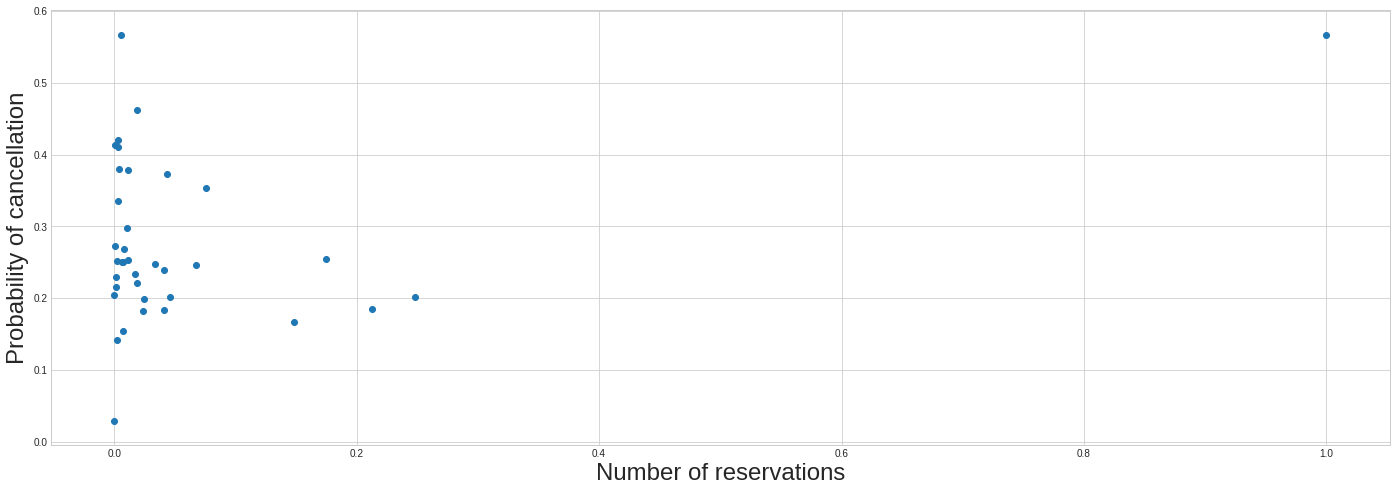

In [12]:
y = probability_per_country.loc[num_reservations_per_country.index]
x = num_reservations_per_country
normalize = lambda x: (x - x.min()) / (x.max() - x.min())

plt.figure(figsize=(24, 8), facecolor='w')
plt.scatter(normalize(x), y)
plt.xlabel('Number of reservations', fontsize=24)
plt.ylabel('Probability of cancellation', fontsize=24)
plt.show()

In [13]:
X_train_mask = X_train.country != 'PRT'
X_train_masked = X_train.loc[X_train_mask]
y_train_masked = y_train.loc[X_train_mask]
models = [_class(**_params).fit(
    X_train_masked, y_train_masked) for _class, _params in zip(model_classes, model_params)]

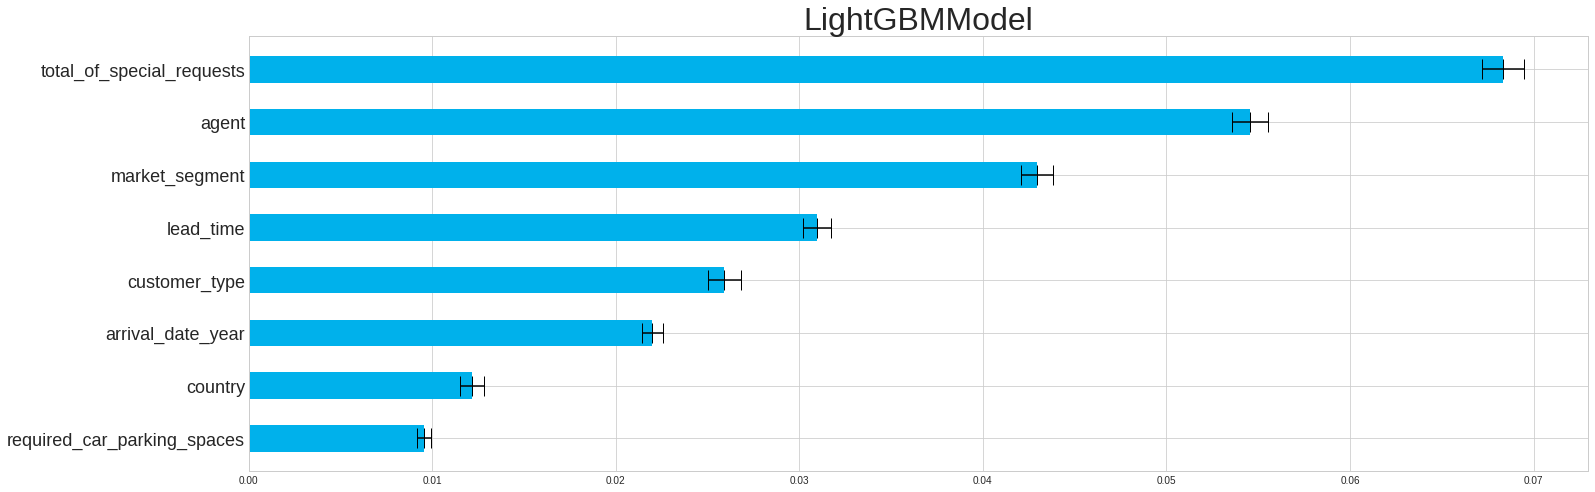

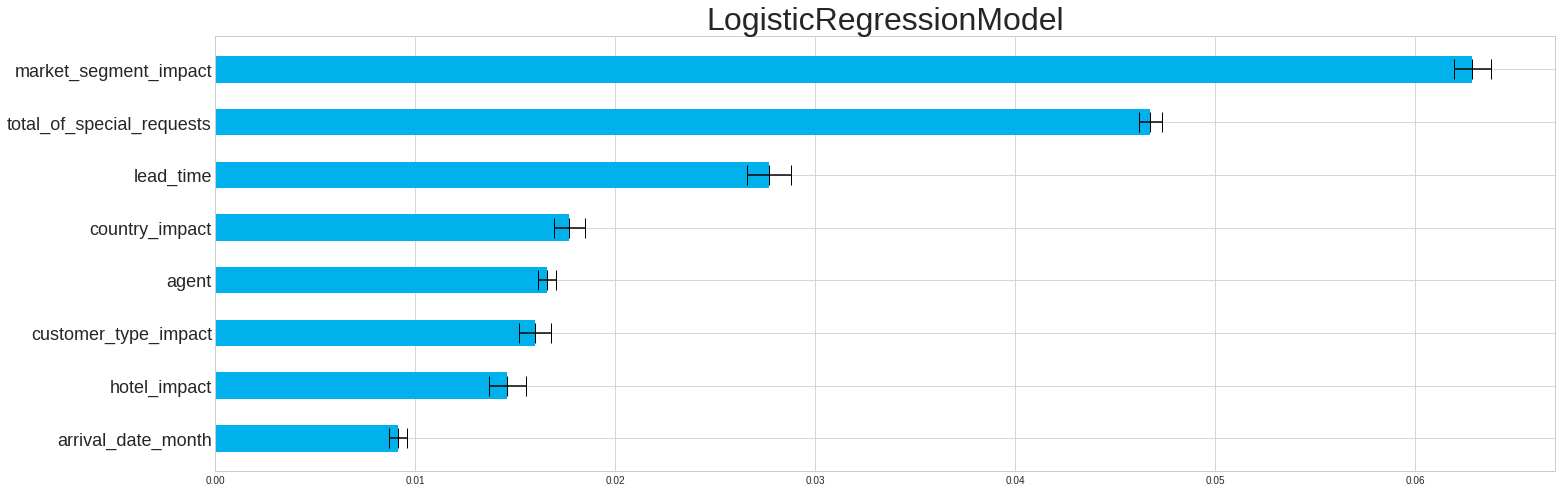

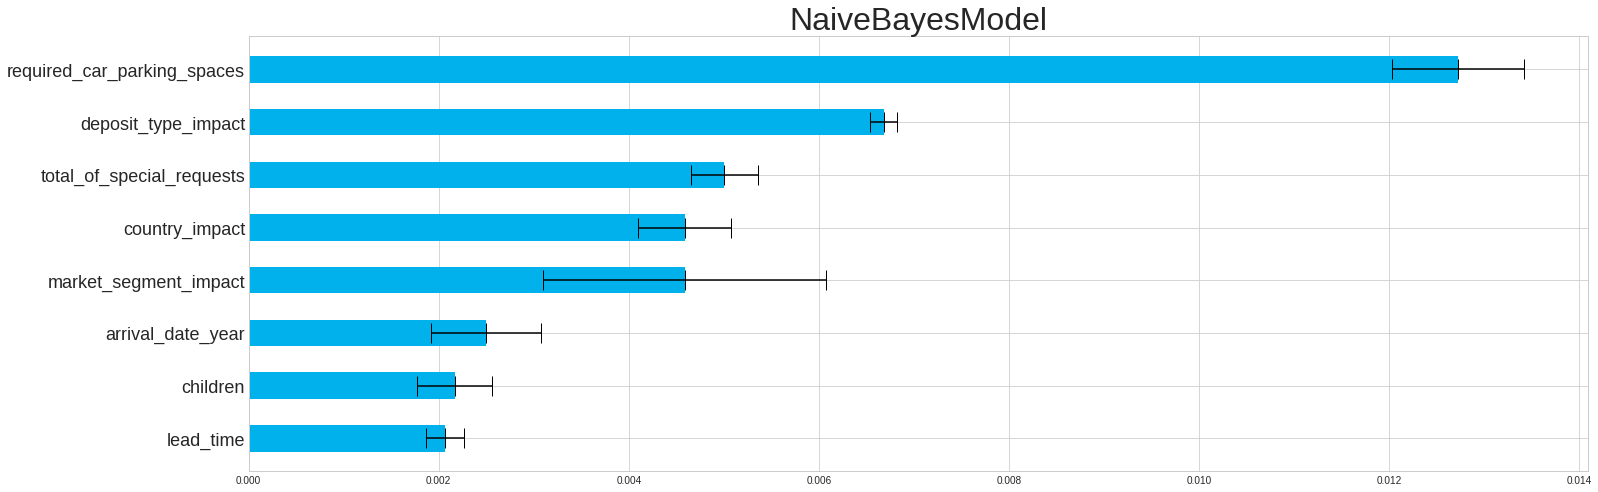

In [14]:
for model in models:
    permutation_importance(model, X_train_masked, y_train_masked, n_repeats=10)